# Sensitivity study: PCA

How does the use of whitening and number of components affect the results?

## Module Imports and Loading Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pickle
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report

import sys
sys.path.insert(0,'../')
from helper import (classification_tools as ct,
                   visualize as vis)
%matplotlib inline

In [2]:
fc1_path = Path('..','data','features','VGG16_fc1_features_std.pickle')
with open(fc1_path, 'rb') as f:
    data = pickle.load(f)

le_path = Path('..','models','label_encoder.pickle')
with open(le_path, 'rb') as f:
    le = pickle.load(f)

In [3]:
files = data['filename']
fc1 = data['features']
labels = data['labels']
y_gt = le.transform(labels)

# PCA models with and without whitening

In [4]:
pca = PCA(n_components=50, svd_solver='full', whiten=True)
pca_nw = PCA(n_components=50, svd_solver='full', whiten=False)
x = pca.fit_transform(fc1)
x_nw = pca_nw.fit_transform(fc1)

In [5]:
tsne = TSNE(n_components=2, random_state=12214)
tsne_w = TSNE(n_components=2, random_state=654753)
x_nw_tsne = tsne.fit_transform(x_nw)
x_w_tsne = tsne_w.fit_transform(x)

# Without whitening cluster accuracy is consistently around 96% with 50 components


In [6]:
rs = np.random.RandomState(seed=1115068143)
for i, seed in enumerate(rs.randint(2**32,size=5), start=1):
    kmeans = KMeans(n_clusters=7, init='k-means++', n_init=50, random_state=seed)
    kmeans.fit(x_nw)
    labels_unmatched = kmeans.labels_
    y_pred = ct.label_matcher(labels_unmatched, y_gt)
    print('trial {}'.format(i))
    print('inertia: {:.2f}'.format(kmeans.inertia_))
    CM = confusion_matrix(y_gt, y_pred)
    print(CM)
    print('Accuracy: {:.3f}\n'.format(CM.trace()/CM.sum()))

trial 1
inertia: 6751225.50
[[300   0   0   0   0   0]
 [  0 269   1  24   4   2]
 [  9   6 280   4   1   0]
 [  3   5   1 290   0   1]
 [  0   0   1   0 299   0]
 [  0  10   0   1   1 288]]
Accuracy: 0.959

trial 2
inertia: 6750616.50
[[300   0   0   0   0   0]
 [  0 273   1  20   5   1]
 [  9   6 279   3   3   0]
 [  3   7   1 288   0   1]
 [  0   0   1   0 299   0]
 [  0   8   0   1   1 290]]
Accuracy: 0.961

trial 3
inertia: 6751263.50
[[300   0   0   0   0   0]
 [  0 269   1  24   4   2]
 [  9   6 279   4   2   0]
 [  3   6   1 289   0   1]
 [  0   0   1   0 299   0]
 [  0  10   0   1   1 288]]
Accuracy: 0.958

trial 4
inertia: 6751155.50
[[300   0   0   0   0   0]
 [  0 269   1  23   4   3]
 [  9   6 280   4   1   0]
 [  3   6   1 289   0   1]
 [  0   0   1   0 299   0]
 [  0   8   0   0   1 291]]
Accuracy: 0.960

trial 5
inertia: 6750608.00
[[300   0   0   0   0   0]
 [  0 273   1  21   4   1]
 [  9   6 280   4   1   0]
 [  3   7   1 288   0   1]
 [  0   0   1   0 299   0]
 [  0

# varying the number of components
Let's look at the fraction of variance explained by all components.
Note that whitening is applied after components are already computed, so
the fraction of variance explained does not change between PCA models with/without whitening
for the same data.

In [7]:
pca_nw = PCA(whiten=False, svd_solver='full')
pca_w = PCA(whiten=True, svd_solver='full')

pca_nw.fit(fc1)
pca_w.fit(fc1)

PCA(svd_solver='full', whiten=True)

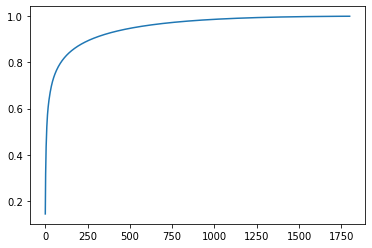

In [8]:
var = pca_w.explained_variance_ratio_.astype(np.float64).cumsum()
plt.plot(var)

In [9]:
nc = [1, 5, 10, 20, 50, 100, 250, 500, 1000, 1800] 
for n, v in zip(nc, var[np.asarray(nc)-1]):
    print('number of components: {}\ntotal fraction of variance: {:.3f}\n'.format(n, v))

number of components: 1
total fraction of variance: 0.144

number of components: 5
total fraction of variance: 0.404

number of components: 10
total fraction of variance: 0.522

number of components: 20
total fraction of variance: 0.621

number of components: 50
total fraction of variance: 0.733

number of components: 100
total fraction of variance: 0.807

number of components: 250
total fraction of variance: 0.893

number of components: 500
total fraction of variance: 0.948

number of components: 1000
total fraction of variance: 0.987

number of components: 1800
total fraction of variance: 1.000



## Now, let's see how the cluster accuracy varies as we change the number of components.

In [10]:
use_cache = True # set to False to re-compute results
pca_nc_cache_path = Path('..','.neu_cache','sensitivity_pca_num_components.pickle')

if not use_cache or not pca_nc_cache_path.is_file(): # run if user specifies (switch=True) or if cached results not found
    accs_w = []
    accs_nw = []
    rs = np.random.RandomState(seed=3731806785)
    for c, seed1, seed2  in zip(nc, 
                                rs.randint(2**32, size=len(nc)), 
                                rs.randint(2**32, size=len(nc))):

        print('number of components: {:>4}'.format(c))
        pca_nw = PCA(whiten=False, svd_solver='full', n_components=c)
        pca_w = PCA(whiten=True, svd_solver='full', n_components=c)

        x_nw = pca_nw.fit_transform(fc1)
        x_w = pca_w.fit_transform(fc1)

        kmeans_nw = KMeans(n_clusters=7, init='k-means++', n_init=500, random_state=seed1)
        kmeans_nw.fit(x_nw)
        labels_unmatched_nw = kmeans_nw.labels_
        y_pred_nw  = ct.label_matcher(labels_unmatched_nw, y_gt)

        CM_nw = confusion_matrix(y_gt, y_pred_nw)
        accs_nw.append(CM_nw.trace()/CM_nw.sum())

        kmeans_w = KMeans(n_clusters=7, init='k-means++', n_init=500, random_state=seed2)
        kmeans_w.fit(x_w)
        labels_unmatched_w = kmeans_w.labels_
        y_pred_w  = ct.label_matcher(labels_unmatched_w, y_gt,)


        CM_w = confusion_matrix(y_gt, y_pred_w)
        accs_w.append(CM_w.trace()/CM_w.sum())
    with open(pca_nc_cache_path, 'wb') as f:
        pickle.dump({'nc':nc,
                'accs_nw':accs_nw,
                'accs_w':accs_w},
               f)
else:
    with open(pca_nc_cache_path, 'rb') as f:
        results_ = pickle.load(f)
        nc = results_['nc']
        accs_nw = results_['accs_nw']
        accs_w = results_['accs_w']
        
        

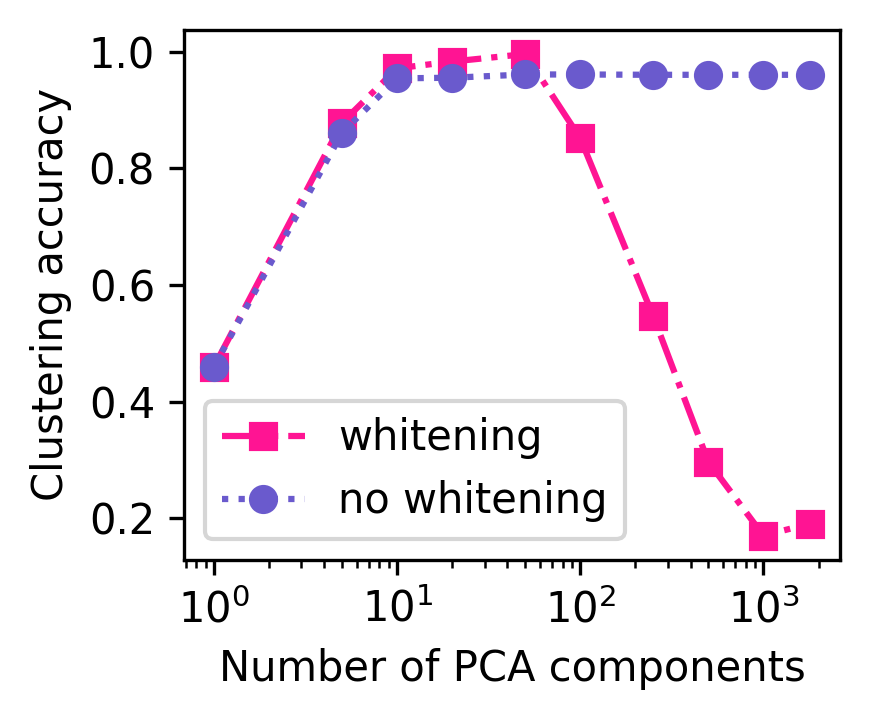

In [11]:
fig = plt.figure(dpi=300, figsize=(3,2.5))
ax = fig.add_subplot(111)
ax.plot(nc, accs_w, '-.sk', label='whitening', color='deeppink')
ax.plot(nc, accs_nw, ':ok', label='no whitening', color='slateblue')
leg = ax.legend()
ax.set_xscale('log')
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('Clustering accuracy')
fig.tight_layout()
fig.savefig(Path('..','Figures','pca_n_components.png'), bbox_inches='tight')

In [12]:
print('number of components\taccuaries (no whitening)\taccuracies (whitening)')
for n, nw, w in zip(nc, accs_nw, accs_w):
    print('\t{:>4}\t\t\t{:.3f}\t\t\t\t{:.3f}'.format(n,nw,w))

number of components	accuaries (no whitening)	accuracies (whitening)
	   1			0.460				0.460
	   5			0.861				0.878
	  10			0.954				0.972
	  20			0.956				0.983
	  50			0.961				0.996
	 100			0.961				0.852
	 250			0.961				0.547
	 500			0.961				0.297
	1000			0.961				0.170
	1800			0.961				0.191


The trend is explained in more detal in the paper. But a quick summary is as follows:
  * For a small number of components, not enough variance is explained for the data to cluster
      * Also, whitening/no whitening have similar performance, because only components with a relatively high fraction of variance explained are included.
        Note that for 1 component, the performance is exactly the same, because scaling a single component does not change the relative positions of points in feature space.
  * For a 'good' number of components, without whitening accuracy tapers off at ~96%, whereas including whitening increases accuracy to >99\%.
      * Whitening enhances the signal from components with smaller magnitudes, allowing data to be better resolved.
  * With too many components, the results without whitening are not affected. These components contain a very small fraction of variance and don't change the relative positions of points much.
  * With too many componenst, whitening is very detrimental to cluster accuracy as noisy components are scaled up to have the same magnitude as other components, drowning out the signal.